In [2]:
import theano
import theano.tensor as T
import numpy as np
import pandas as pd
import cPickle as pkl
from matplotlib import pyplot as plt

In [37]:
""" Linear Total Correlation Explanation
Recovers linear latent factors from data, like PCA/ICA/FA, etc. except that
these factors are maximally informative about relationships in the data.
We also constrain our solutions to be "non-synergistic" for better interpretability.
(That is the TC(Y|Xi)=0 constraint in the "blessing of dimensionality" paper.)
Code below written by:
Greg Ver Steeg (gregv@isi.edu), 2017.
"""

from scipy.stats import norm, rankdata
import gc
try:
    import cudamat as cm
    GPU_SUPPORT = True
except:
    print("Install CUDA and cudamat (for python) to enable GPU speedups.")
    GPU_SUPPORT = False


class Corex(object):
    """
    Linear Total Correlation Explanation
    Conventions
    ----------
    Code follows sklearn naming/style (e.g. fit(X) to train, transform() to apply model to test data).
    Parameters
    ----------
    n_hidden : int, default = 2
        The number of latent factors to use.
    max_iter : int, default = 10000
        The max. number of iterations to reach convergence.
    tol : float, default = 0.0001
        Used to test for convergence.
    eliminate_synergy : bool, default = True
        Use a constraint that the information latent factors have about data is not synergistic.
    gaussianize : str, default = 'standard'
        Preprocess data so each marginal is near a standard normal. See gaussianize method for more details.
    yscale : float default = 1
        We imagine some small fundamental measurement noise on Y. The value is arbitrary, but it sets
        the scale of the results, Y.
    verbose : int, optional
        Print verbose outputs.
    seed : integer or numpy.RandomState, optional
        A random number generator instance to define the state of the
        random permutations generator. If an integer is given, it fixes the
        seed. Defaults to the global numpy random number generator.
    Attributes
    ----------
    References
    ----------
    [1] Greg Ver Steeg and Aram Galstyan. "Maximally Informative Hierarchical...", AISTATS 2015.
    [2] Greg Ver Steeg, Shuyang Gao, Kyle Reing, and Aram Galstyan. "Sifting Common Information from Many Variables",
                                                                    IJCAI 2017.
    [3] Greg Ver Steeg and Aram Galstyan. "Low Complexity Gaussian Latent Factor Models and
                                           a Blessing of Dimensionality", 2017.
    """

    def __init__(self, n_hidden=10, max_iter=10000, tol=1e-5, anneal=True, missing_values=None,
                 discourage_overlap=True, gaussianize='standard', gpu=False,
                 verbose=False, seed=None):
        self.m = n_hidden  # Number of latent factors to learn
        self.max_iter = max_iter  # Number of iterations to try
        self.tol = tol  # Threshold for convergence
        self.anneal = anneal
        self.eps = 0  # If anneal is True, it's adjusted during optimization to avoid local minima
        self.missing_values = missing_values

        self.discourage_overlap = discourage_overlap  # Whether or not to discourage overlapping latent factors
        self.gaussianize = gaussianize  # Preprocess data: 'standard' scales to zero mean and unit variance
        self.gpu = gpu  # Enable GPU support for some large matrix multiplications.
        if self.gpu:
            cm.cublas_init()

        self.yscale = 1.  # Can be arbitrary, but sets the scale of Y
        np.random.seed(seed)  # Set seed for deterministic results
        self.verbose = verbose
        if verbose:
            np.set_printoptions(precision=3, suppress=True, linewidth=160)
            print(('Linear CorEx with {:d} latent factors'.format(n_hidden)))

        # Initialize these when we fit on data
        self.n_samples, self.nv = 0, 0  # Number of samples/variables in input data
        self.ws = np.zeros((0, 0))  # m by nv array of weights
        self.moments = {}  # Dictionary of moments
        self.theta = None  # Parameters for preprocessing each variable
        self.history = {}  # Keep track of values for each iteration
        self.last_update = 0  # Used for momentum methods

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

    def fit(self, x):
        x = np.asarray(x, dtype=np.float32)
        x = self.preprocess(x, fit=True)  # Fit a transform for each marginal
        self.n_samples, self.nv = x.shape  # Number of samples, variables in input data
        if self.m is None:
            self.m = pick_n_hidden(x)
        anneal_schedule = [0.]
        if self.ws.size == 0:  # Randomly initialize weights if not already set
            if self.discourage_overlap:
                self.ws = np.random.randn(self.m, self.nv).astype(np.float32)
                self.ws /= (10. * self._norm(x, self.ws))[:, np.newaxis]  # TODO: test good IC
                if self.anneal:
                    anneal_schedule = [0.6**k for k in range(1, 7)] + [0]
            else:
                self.ws = np.random.randn(self.m, self.nv) * self.yscale ** 2 / np.sqrt(self.nv)
        self.moments = self._calculate_moments(x, self.ws, quick=True)

        for i_eps, eps in enumerate(anneal_schedule):
            self.eps = eps
            if i_eps > 0:
                eps0 = anneal_schedule[i_eps - 1]
                mag = (1 - self.yscale**2 / self.moments['Y_j^2']).clip(1e-5)  # May be better to re-initialize un-used latent factors (i.e. yj^2=self.yscale**2)?
                wmag = np.sum(self.ws**2, axis=1)
                self.ws *= np.sqrt((1 - eps0**2) / (1 - eps**2 - (eps0**2 - eps**2) * wmag / mag))[:, np.newaxis]
            self.moments = self._calculate_moments(x, self.ws, quick=True)

            for i_loop in range(self.max_iter):
                last_tc = self.tc  # Save this TC to compare to possible updates
                if self.discourage_overlap:
                    self.ws, self.moments = self._update_ns(x)
                else:
                    self.ws, self.moments = self._update_syn(x, eta=0.1)  # Older method that allows synergies

                # assert np.isfinite(self.tc), "Error: TC is no longer finite: {}".format(self.tc)
                if not self.moments or not np.isfinite(self.tc):
                    try:
                        print(("Error: TC is no longer finite: {}".format(self.tc)))
                    except:
                        print("Error... updates giving invalid solutions?")
                        return self
                delta = np.abs(self.tc - last_tc)
                self.update_records(self.moments, delta)  # Book-keeping
                if delta < self.tol:  # Check for convergence
                    if self.verbose:
                        print(('{:d} iterations to tol: {:f}'.format(i_loop, self.tol)))
                    break
            else:
                if self.verbose:
                    print(("Warning: Convergence not achieved in {:d} iterations. "
                          "Final delta: {:f}".format(self.max_iter, delta.sum())))
        self.moments = self._calculate_moments(x, self.ws, quick=False)  # Update moments with details
        order = np.argsort(-self.moments["TCs"])  # Largest TC components first.
        self.ws = self.ws[order]
        self.moments = self._calculate_moments(x, self.ws, quick=False)  # Update moments based on sorted weights.
        return self

    def update_records(self, moments, delta):
        """Print and store some statistics about each iteration."""
        gc.disable()  # There's a bug that slows when appending, fixed by temporarily disabling garbage collection
        self.history["TC"] = self.history.get("TC", []) + [moments["TC"]]
        if self.verbose > 1:
            print(("TC={:.3f}\tadd={:.3f}\tdelta={:.6f}".format(moments["TC"], moments.get("additivity", 0), delta)))
        if self.verbose:
            self.history["additivity"] = self.history.get("additivity", []) + [moments.get("additivity", 0)]
            self.history["TCs"] = self.history.get("TCs", []) + [moments.get("TCs", np.zeros(self.m))]
        gc.enable()

    @property
    def tc(self):
        """This actually returns the lower bound on TC that is optimized. The lower bound assumes a constraint that
         would be satisfied by a non-overlapping model.
         Check "moments" for two other estimates of TC that may be useful."""
        return self.moments["TC"]

    @property
    def tcs(self):
        """TCs for each individual latent factor. They DO NOT sum to TC in this case, because of overlaps."""
        return self.moments["TCs"]

    @property
    def mis(self):
        return - 0.5 * np.log1p(-self.moments["rho"]**2)

    def clusters(self):
        return np.argmax(np.abs(self.ws), axis=0)

    def _sig(self, x, u):
        """Multiple the matrix u by the covariance matrix of x. We are interested in situations where
        n_variables >> n_samples, so we do this without explicitly constructing the covariance matrix."""
        if self.gpu:
            y = cm.empty((self.n_samples, self.m))
            uc = cm.CUDAMatrix(u)
            cm.dot(x, uc.T, target=y)
            del uc
            tmp = cm.empty((self.nv, self.m))
            cm.dot(x.T, y, target=tmp)
            tmp_dot = tmp.asarray()
            del y
            del tmp
        else:
            y = x.dot(u.T)
            tmp_dot = x.T.dot(y)
        prod = (1 - self.eps**2) * tmp_dot.T / self.n_samples + self.eps**2 * u  # nv by m,  <X_i Y_j> / std Y_j
        return prod

    def _norm(self, x, ws):
        """Calculate uj so that we can normalize it."""
        if self.gpu:
            y = cm.empty((self.n_samples, self.m))
            wc = cm.CUDAMatrix(ws)
            cm.dot(x, wc.T, target=y)  # + noise, but it is included analytically
            y_local = y.asarray()
            del y
            del wc
            tmp_sum = np.einsum('lj,lj->j', y_local, y_local)  # TODO: Should be able to do on gpu...
        else:
            y = x.dot(ws.T)  # + noise / std Y_j^2, but it is included analytically
            tmp_sum = np.einsum('lj,lj->j', y, y)
        return np.sqrt((1 - self.eps**2) * tmp_sum / self.n_samples + self.eps**2 * np.sum(ws**2, axis=1))

    def _calculate_moments(self, x, ws, quick=False):
        if self.discourage_overlap:
            return self._calculate_moments_ns(x, ws, quick=quick)
        else:
            return self._calculate_moments_syn(x, ws, quick=quick)

    def _calculate_moments_ns(self, x, ws, quick=False):
        """Calculate moments based on the weights and samples. We also calculate and save MI, TC, additivity, and
        the value of the objective. Note it is assumed that <X_i^2> = 1! """
        m = {}  # Dictionary of moments
        if self.gpu:
            y = cm.empty((self.n_samples, self.m))
            wc = cm.CUDAMatrix(ws)
            cm.dot(x, wc.T, target=y)  # + noise, but it is included analytically
            del wc
            tmp_sum = np.einsum('lj,lj->j', y.asarray(), y.asarray())  # TODO: Should be able to do on gpu...
        else:
            y = x.dot(ws.T)
            tmp_sum = np.einsum('lj,lj->j', y, y)
        m["uj"] = (1 - self.eps**2) * tmp_sum / self.n_samples + self.eps**2 * np.sum(ws**2, axis=1)
        if quick and np.max(m["uj"]) >= 1.:
            return False
        if self.gpu:
            tmp = cm.empty((self.nv, self.m))
            cm.dot(x.T, y, target=tmp)
            tmp_dot = tmp.asarray()
            del tmp
            del y
        else:
            tmp_dot = x.T.dot(y)
        m["rho"] = (1 - self.eps**2) * tmp_dot.T / self.n_samples + self.eps**2 * ws  # m by nv
        m["ry"] = ws.dot(m["rho"].T)  # normalized covariance of Y
        m["Y_j^2"] = self.yscale ** 2 / (1. - m["uj"])
        np.fill_diagonal(m["ry"], 1)
        m["invrho"] = 1. / (1. - m["rho"]**2)
        m["rhoinvrho"] = m["rho"] * m["invrho"]
        m["Qij"] = np.dot(m['ry'], m["rhoinvrho"])
        m["Qi"] = np.einsum('ki,ki->i', m["rhoinvrho"], m["Qij"])
        #m["Qi-Si^2"] = np.einsum('ki,ki->i', m["rhoinvrho"], m["Qij"])
        m["Si"] = np.sum(m["rho"] * m["rhoinvrho"], axis=0)

        # This is the objective, a lower bound for TC
        m["TC"] = np.sum(np.log(1 + m["Si"])) \
                     - 0.5 * np.sum(np.log(1 - m["Si"]**2 + m["Qi"])) \
                     + 0.5 * np.sum(np.log(1 - m["uj"]))

        if not quick:
            m["MI"] = - 0.5 * np.log1p(-m["rho"]**2)
            m["X_i Y_j"] = m["rho"].T * np.sqrt(m["Y_j^2"])
            m["X_i Z_j"] = np.linalg.solve(m["ry"], m["rho"]).T
            m["X_i^2 | Y"] = (1. - np.einsum('ij,ji->i', m["X_i Z_j"], m["rho"])).clip(1e-6)
            m['I(Y_j ; X)'] = 0.5 * np.log(m["Y_j^2"]) - 0.5 * np.log(self.yscale ** 2)
            m['I(X_i ; Y)'] = - 0.5 * np.log(m["X_i^2 | Y"])
            m["TCs"] = m["MI"].sum(axis=1) - m['I(Y_j ; X)']
            m["TC_no_overlap"] = m["MI"].max(axis=0).sum() - m['I(Y_j ; X)'].sum()  # A direct calculation of TC where each variable is in exactly one group.
            m["TC_direct"] = m['I(X_i ; Y)'].sum() - m['I(Y_j ; X)']  # A direct calculation of TC. Should be upper bound for "TC", "TC_no_overlap"
            m["additivity"] = (m["MI"].sum(axis=0) - m['I(X_i ; Y)']).sum()
        return m

    def _update_ns(self, x):
        """Perform one update of the weights and re-calculate moments in the NON-SYNERGISTIC case."""
        m = self.moments
        rj = 1. - m["uj"][:, np.newaxis]
        H = np.dot(m["rhoinvrho"] / (1 + m["Qi"] - m["Si"]**2), m["rhoinvrho"].T)
        np.fill_diagonal(H, 0)
        grad = self.ws / rj
        grad -= 2 * m["invrho"] * m["rhoinvrho"] / (1 + m["Si"])
        grad += m["invrho"]**2 * \
               ((1 + m["rho"]**2) * m["Qij"] - 2 * m["rho"] * m["Si"]) / (1 - m["Si"]**2 + m["Qi"])
        grad += np.dot(H, self.ws)
        sig_grad = self._sig(x, grad)
        
        Bj = np.sum(m["rho"] * grad, axis=1, keepdims=True)
        update = - rj * (grad - 2. * self.ws / (2 - rj) * Bj)  # Gamma Hess^-1 Grad
        update = np.where(rj < 1e-6, 0, update)

        backtrack = True
        eta = 1.
        update_tangent = np.einsum('ji,ji', sig_grad, update)
        while backtrack:
            if eta < min(self.tol, 1e-10):
                if self.verbose:
                    print('Warning: step size becoming too small')
                break
            w_update = self.ws + eta * update
            m_update = self._calculate_moments_ns(x, w_update, quick=True)
            if not m_update:  # TEST 1: Make sure rho is a valid solution, if not m_update will return False
                eta *= 0.5
                if self.verbose > 1:
                    print(('back:{:.7f}'.format(eta)))
                continue
            wolfe1 = -m_update['TC'] <= -m['TC'] + 0.1 * eta * update_tangent
            if not wolfe1:  # TEST 2: the first wolfe condition (sufficient decrease)
                eta *= 0.5
                if self.verbose > 1:
                    print(('wolfe1:{:.7f}'.format(eta)))
                continue
            backtrack = False
        print self.tc
        """
        return

        eta = 1e-3
        while True:
            w_update = self.ws - eta * sig_grad
            m_update = self._calculate_moments_ns(x, w_update, quick=True)
            if m_update:
                break

        """
        return w_update, m_update

    def _calculate_moments_syn(self, x, ws, quick=False):
        """Calculate moments based on the weights and samples. We also calculate and save MI, TC, additivity, and
        the value of the objective. Note it is assumed that <X_i^2> = 1! """
        m = {}  # Dictionary of moments
        if self.gpu:
            y = cm.empty((self.n_samples, self.m))
            wc = cm.CUDAMatrix(ws)
            cm.dot(x, wc.T, target=y)  # + noise, but it is included analytically
            del wc
        else:
            y = x.dot(ws.T)  # + noise, but it is included analytically
        if self.gpu:
            tmp_dot = cm.empty((self.nv, self.m))
            cm.dot(x.T, y, target=tmp_dot)
            m["X_i Y_j"] = tmp_dot.asarray() / self.n_samples  # nv by m,  <X_i Y_j>
            del y
            del tmp_dot
        else:
            m["X_i Y_j"] = x.T.dot(y) / self.n_samples
        m["cy"] = ws.dot(m["X_i Y_j"]) + self.yscale ** 2 * np.eye(self.m)  # cov(y.T), m by m
        m["Y_j^2"] = np.diag(m["cy"]).copy()
        m["ry"] = m["cy"] / (np.sqrt(m["Y_j^2"]) * np.sqrt(m["Y_j^2"][:, np.newaxis]))
        m["rho"] = (m["X_i Y_j"] / np.sqrt(m["Y_j^2"])).T
        m["invrho"] = 1. / (1. - m["rho"]**2)
        m["rhoinvrho"] = m["rho"] * m["invrho"]
        m["Qij"] = np.dot(m['ry'], m["rhoinvrho"])
        m["Qi"] = np.einsum('ki,ki->i', m["rhoinvrho"], m["Qij"])
        m["Si"] = np.sum(m["rho"] * m["rhoinvrho"], axis=0)

        m["MI"] = - 0.5 * np.log1p(-m["rho"]**2)
        m["X_i Z_j"] = np.linalg.solve(m["cy"], m["X_i Y_j"].T).T
        m["X_i^2 | Y"] = (1. - np.einsum('ij,ij->i', m["X_i Z_j"], m["X_i Y_j"])).clip(1e-6)
        mi_yj_x = 0.5 * np.log(m["Y_j^2"]) - 0.5 * np.log(self.yscale ** 2)
        mi_xi_y = - 0.5 * np.log(m["X_i^2 | Y"])
        m["TCs"] = m["MI"].sum(axis=1) - mi_yj_x
        m["additivity"] = (m["MI"].sum(axis=0) - mi_xi_y).sum()
        m["TC"] = np.sum(mi_xi_y) - np.sum(mi_yj_x)
        return m

    def _update_syn(self, x, eta=0.5):
        """Perform one update of the weights and re-calculate moments in the SYNERGISTIC case."""
        m = self.moments
        H = (1. / m["X_i^2 | Y"] * m["X_i Z_j"].T).dot(m["X_i Z_j"])
        np.fill_diagonal(H, 0)
        R = m["X_i Z_j"].T / m["X_i^2 | Y"]
        S = np.dot(H, self.ws)
        ws = (1. - eta) * self.ws + eta * (R - S)
        m = self._calculate_moments_syn(x, ws)
        return ws, m

    def transform(self, x, details=False):
        """Transform an array of inputs, x, into an array of k latent factors, Y.
            Optionally, you can get the remainder information and/or stop at a specified level."""
        x = self.preprocess(x)
        ns, nv = x.shape
        assert self.nv == nv, "Incorrect number of variables in input, %d instead of %d" % (nv, self.nv)
        if details:
            moments = self._calculate_moments(x, self.ws)
            return x.dot(self.ws.T), moments
        return x.dot(self.ws.T)

    def preprocess(self, x, fit=False):
        """Transform each marginal to be as close to a standard Gaussian as possible.
        'standard' (default) just subtracts the mean and scales by the std.
        'empirical' does an empirical gaussianization (but this cannot be inverted).
        'outliers' tries to squeeze in the outliers
        Any other choice will skip the transformation."""
        if self.missing_values is not None:
            x, self.n_obs = mean_impute(x, self.missing_values)  # Creates a copy
        else:
            self.n_obs = len(x)
        if self.gaussianize == 'none':
            pass
        elif self.gaussianize == 'standard':
            if fit:
                mean = np.mean(x, axis=0)
                # std = np.std(x, axis=0, ddof=0).clip(1e-10)
                std = np.sqrt(np.sum((x - mean)**2, axis=0) / self.n_obs).clip(1e-10)
                self.theta = (mean, std)
            x = ((x - self.theta[0]) / self.theta[1])
            if np.max(np.abs(x)) > 6 and self.verbose:
                print("Warning: outliers more than 6 stds away from mean. Consider using gaussianize='outliers'")
        elif self.gaussianize == 'outliers':
            if fit:
                mean = np.mean(x, axis=0)
                std = np.std(x, axis=0, ddof=0).clip(1e-10)
                self.theta = (mean, std)
            x = g((x - self.theta[0]) / self.theta[1])  # g truncates long tails
        elif self.gaussianize == 'empirical':
            print("Warning: correct inversion/transform of empirical gauss transform not implemented.")
            x = np.array([norm.ppf((rankdata(x_i) - 0.5) / len(x_i)) for x_i in x.T]).T
        if self.gpu and fit:  # Don't return GPU matrices when only transforming
            x = cm.CUDAMatrix(x)
        return x

    def invert(self, x):
        """Invert the preprocessing step to get x's in the original space."""
        if self.gaussianize == 'standard':
            return self.theta[1] * x + self.theta[0]
        elif self.gaussianize == 'outliers':
            return self.theta[1] * g_inv(x) + self.theta[0]
        else:
            return x

    def predict(self, y):
        return self.invert(np.dot(self.moments["X_i Z_j"], y.T).T)

    def get_covariance(self):
        # This uses E(Xi|Y) formula for non-synergistic relationships
        m = self.moments
        if self.discourage_overlap:
            z = m['rhoinvrho'] / (1 + m['Si'])
            cov = np.dot(z.T, z)
            cov /= (1. - self.eps**2)
            np.fill_diagonal(cov, 1)
            return self.theta[1][:, np.newaxis] * self.theta[1] * cov
        else:
            cov = np.einsum('ij,kj->ik', m["X_i Z_j"], m["X_i Y_j"])
            np.fill_diagonal(cov, 1)
            return self.theta[1][:, np.newaxis] * self.theta[1] * cov


def pick_n_hidden(data, repeat=1, verbose=False):
    """A helper function to pick the number of hidden factors / clusters to use."""
    # TODO: Use an efficient search strategy
    max_score = - np.inf
    n = 1
    while True:
        scores = []
        for _ in range(repeat):
            out = Corex(n_hidden=n, max_iter=1000, tol=1e-3, gpu=False).fit(data)
            m = out.moments
            scores.append(m["TC_no_overlap"])
        score = max(scores)
        if verbose:
            print(("n: {}, score: {}".format(n, score)))
        if score < max_score:
            break
        else:
            n += 1
            max_score = score
    return n - 1


def g(x, t=4):
    """A transformation that suppresses outliers for a standard normal."""
    xp = np.clip(x, -t, t)
    diff = np.tanh(x - xp)
    return xp + diff


def g_inv(x, t=4):
    """Inverse of g transform."""
    xp = np.clip(x, -t, t)
    diff = np.arctanh(np.clip(x - xp, -1 + 1e-10, 1 - 1e-10))
    return xp + diff


def mean_impute(x, v):
    """Missing values in the data, x, are indicated by v. Wherever this value appears in x, it is replaced by the
    mean value taken from the marginal distribution of that column."""
    if not np.isnan(v):
        x = np.where(x == v, np.nan, x)
    x_new = []
    n_obs = []
    for i, xi in enumerate(x.T):
        missing_locs = np.where(np.isnan(xi))[0]
        xi_nm = xi[np.isfinite(xi)]
        xi[missing_locs] = np.mean(xi_nm)
        x_new.append(xi)
        n_obs.append(len(xi_nm))
    return np.array(x_new).T, np.array(n_obs)


def random_impute(x, v):
    """Missing values in the data, x, are indicated by v. Wherever this value appears in x, it is replaced by a
    random value taken from the marginal distribution of that column."""
    if not np.isnan(v):
        x = np.where(x == v, np.nan, x)
    x_new = []
    for i, xi in enumerate(x.T):
        missing_locs = np.where(np.isnan(xi))[0]
        xi_nm = xi[np.isfinite(xi)]
        xi[missing_locs] = np.random.choice(xi_nm, size=len(missing_locs))
        x_new.append(xi)
    return np.array(x_new).T


Install CUDA and cudamat (for python) to enable GPU speedups.


# Load Data

In [4]:
def load_data():
    with open('../data/EOD_week.pkl', 'rb') as f:
        df = pd.DataFrame(pkl.load(f))
    return df

df = load_data()
print("Data.shape = {}".format(df.shape))

Data.shape = (887, 5038)


In [22]:
X = df[0:200]
corex_params = {
    'n_hidden':10,
    'max_iter':10000,
    'tol':1e-5,
    'anneal':True,
    'missing_values':None,
    'discourage_overlap':True,
    'gaussianize':'standard',
    'gpu':False,
    'verbose':True,
    'seed':None
}

In [38]:
corex = Corex(**corex_params)
corex.fit(X)

Linear CorEx with 10 latent factors
1.32054558769
61.4319650233
68.10110569
171.619467974
202.210778475
213.827741146
230.264513254
240.721321106
250.145879745
264.320951939
271.728287697
288.965360641
309.675861359
318.389801979
325.330291748
337.178912163
342.439762115
347.277527809
350.564861298
352.870290756
354.487724304
355.591526031
355.917139053
356.338275909
357.069791794
357.540035248
357.912008286
358.206850052
358.451532364
358.664319992
358.852712631
359.022014618
359.17490387
359.313959122
359.440923691
359.557540894
359.664422989
359.762331009
359.851970673
359.933366776
360.007352829
360.07412529
360.134458542
360.188146591
360.236709595
360.27983284
360.319862366
360.426549911
360.590631485
360.632440567
360.654026031
360.671413422
360.728069305
360.809854507
360.820396423
360.85881424
360.908416748
360.945516586
360.975498199
361.019868851
361.028730392
361.086578369
361.101745605
361.122154236
361.156572342
361.182582855
361.200708389
361.239852905
361.254695892
361.

363.519807816
363.520425797
363.521972656
363.522186279
363.522567749
363.523122787
363.523900986
363.52432251
363.524513245
363.525022507
363.525556564
363.526205063
363.526475906
363.527257919
363.527721405
363.527954102
363.528507233
363.528774261
363.529733658
363.530012131
363.530344009
363.530965805
363.532241821
363.53260231
363.533065796
363.533514023
363.534030914
363.534440994
363.535161972
363.535497665
363.535673141
363.536365509
363.536542892
363.537261963
363.537734985
363.537908554
363.538471222
363.53868866
363.539562225
363.53994751
363.540201187
363.540815353
363.541965485
363.542152405
363.542549133
363.543174744
363.543739319
363.543899536
363.544704437
363.544967651
363.545188904
363.545631409
363.545951843
363.546640396
363.546979904
363.547157288
363.547685623
363.548007965
363.548639297
363.548776627
363.5496521
363.549757004
363.550008774
363.550584793
363.550926208
363.551080704
363.551553726
363.551967621
363.55257988
363.552898407
363.553199768
363.553443909

534.217226028
534.218402863
534.219070435
534.219697952
534.220859528
534.222414017
534.222795486
534.223590851
534.22423172
534.22615242
534.226501465
534.227672577
534.228439331
534.22910881
534.230051041
534.231737137
534.23208046
534.232976913
534.233568192
534.235641479
534.236091614
534.236555099
534.236837387
534.237674713
534.23859787
534.2402668
534.240690231
534.241664886
534.242523193
534.243114471
534.244422913
534.245763779
534.24640274
534.247138977
534.247911453
534.249862671
534.25018692
534.251279831
534.252161026
534.252866745
534.253833771
534.255592346
534.256061554
534.257165909
534.257534027
534.259809494
534.260087967
534.261316299
534.262119293
534.262897491
534.263658524
534.265863419
534.266138077
534.267337799
534.268266678
534.26889801
534.270118713
534.271736145
534.272388458
534.273447037
534.273797989
534.276254654
534.276981354
534.277418137
534.2780056
534.279705048
534.280851364
534.281860352
534.28263092
534.284042358
534.285703659
534.286298752
534.2

537.643169403
537.643701553
537.644926071
537.647035599
537.647668839
537.648075104
537.648687363
537.650775909
537.651321411
537.651760101
537.652196884
537.652698517
537.653123856
537.653594971
537.654287338
537.655954361
537.656316757
537.656787872
537.657203674
537.657474518
537.657728195
537.658172607
537.659025192
537.660621643
537.66087532
537.661241531
537.661497116
537.661836624
537.662542343
537.664041519
537.664396286
537.664560318
537.664945602
537.665151596
537.665378571
537.666250229
537.667266846
537.667778015
537.667921066
537.668273926
537.668498993
537.669248581
537.670360565
537.670497894
537.670816422
537.671066284
537.671325684
537.671714783
537.672010422
537.673252106
537.67348671
537.673789978
537.674039841
537.67517662
537.675302505
537.675937653
537.676864624
537.677009583
537.677358627
537.677635193
537.678581238
537.678718567
537.678934097
537.679283142
537.679460526
537.679679871
537.68062973
537.680990219
537.681058884
537.681280136
537.681434631
537.681587

In [29]:
corex.tc

-3.8160852193832397

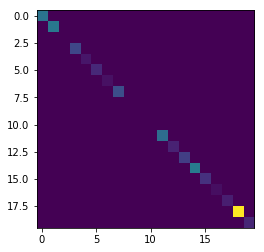

In [30]:
plt.imshow(corex.get_covariance()[:20, :20])
plt.show()

In [10]:
m = corex.moments

In [11]:
for k,v in m.iteritems():
    print k, np.shape(v)

X_i^2 | Y (5038,)
Y_j^2 (10,)
TC_no_overlap ()
I(X_i ; Y) (5038,)
Qij (10, 5038)
rhoinvrho (10, 5038)
I(Y_j ; X) (10,)
MI (10, 5038)
ry (10, 10)
X_i Y_j (5038, 10)
invrho (10, 5038)
Si (5038,)
TCs (10,)
rho (10, 5038)
uj (10,)
Qi (5038,)
X_i Z_j (5038, 10)
additivity ()
TC_direct (10,)
TC ()
